# Information Theoretic Quantum Phase Estimation for Hydrogen with Iceberg Code

This is needed to debug `CUDA-Q` calls:

In [1]:
# import os

# os.environ["CUDAQ_LOG_LEVEL"] = "info"
# os.environ["CUDAQ_LOG_LEVEL"] = "trace"

## Using `pytket` to generate a set of circuits: this will be our baseline

We rely on the `algorithm` module in the `sca25_demo_qpe` repository:

In [2]:
import numpy as np
from algorithm import generate_ks

In [3]:
# Prepare the samples of (k, beta).
k_max = 16
n_samples = 50  # this will set how many circuits we need to run for the QPE
error_rate = 0.0 # this is for the noise model on H1-1


def error_rate_func(k: int) -> float:
    q = 1 - (1 - error_rate) ** k
    return q


k_list = generate_ks(k_max, n_samples, error_rate=error_rate_func)
beta_list = (1 - 2 * np.random.random(size=n_samples)).tolist()


## Hamiltonian for the tapered 1-qubit Hydrogen molecule: the controlled unitary is directly implemented

In [4]:
# 1-qubit controlled Hamiltonian trotterization coefficients
CZ = 0.7960489286466914
CX = -0.1809233927385484
CI = -0.3209561440881913
DELTAT = 0.1
# Exact energy
FCI_ENERGY = -1.13730605

## `pytket` circuit

In [5]:
from typing import Callable
from pytket.circuit import Circuit, Bit
from pytket.backends.backendresult import BackendResult
from pytket.utils.outcomearray import OutcomeArray
from typing import Counter
from pytket.circuit.display import render_circuit_jupyter as draw


def get_qpe_func_iceberg(syndrome_interval: int) -> Callable[[int, float], Circuit]:

    def qpe_func_iceberg(k: int, beta: float) -> Circuit:
        """Hard-coded QPE circuit function."""
        # Qubit register mapping:
        # [t, 0, 1, b, f0, f1]
        # Bit register mapping:
        # [a0, a1, a2, a3, discard]
        circ = Circuit(6, 5)
        # === FT plus state preparation ===
        circ.H(0)
        circ.CX(0, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(0, 1)
        circ.add_barrier(circ.qubits)
        circ.CX(0, 4)
        circ.add_barrier(circ.qubits)
        circ.H(0)
        circ.H(1)
        circ.H(2)
        circ.Measure(4, 0)
        circ.CX(2, 5)
        circ.add_barrier(circ.qubits)
        circ.CX(2, 3)
        circ.add_barrier(circ.qubits)
        circ.CX(2, 5)
        circ.Measure(5, 1)
        circ.add_classicalexpbox_bit(
            circ.bits[0] | circ.bits[1],
            [circ.bits[4]],
        )
        circ.add_barrier(circ.qubits)
        # === Logical operations ===
        # HF state preparation.
        circ.X(0)
        circ.X(2)
        # ctrl-U^{k} and Rz(beta) operations.
        for ii in range(k):
            circ.ZZPhase(CZ*DELTAT, 2, 3)
            circ.ZZPhase(-CZ*DELTAT, 1, 2)
            circ.XXPhase(CX*DELTAT, 0, 2)
            circ.YYPhase(CX*DELTAT, 0, 2)
            if ii + 1 >= k:
                break
            if (ii + 1) % syndrome_interval == 0:
                circ.add_barrier(circ.qubits)
                circ.Reset(4)
                circ.Reset(5)
                circ.H(5)
                circ.CX(5, 0)
                circ.add_barrier(circ.qubits)
                circ.CX(0, 4)
                circ.add_barrier(circ.qubits)
                circ.CX(1, 4)
                circ.add_barrier(circ.qubits)
                circ.CX(5, 1)
                circ.add_barrier(circ.qubits)
                circ.CX(5, 2)
                circ.add_barrier(circ.qubits)
                circ.CX(2, 4)
                circ.add_barrier(circ.qubits)
                circ.CX(3, 4)
                circ.add_barrier(circ.qubits)
                circ.CX(5, 3)
                circ.add_barrier(circ.qubits)
                circ.Measure(4, 0)
                circ.H(5)
                circ.Measure(5, 1)
                circ.add_classicalexpbox_bit(
                    circ.bits[0] | circ.bits[1] | circ.bits[4],
                    [circ.bits[4]],
                )
                circ.add_barrier(circ.qubits)
        circ.add_barrier(circ.qubits)
        circ.ZZPhase(-CI*DELTAT*k + beta, 1, 3)
        # === FT measurements ===
        circ.add_barrier(circ.qubits)
        circ.Reset(4)
        circ.Reset(5)
        circ.CX(0, 4)
        circ.H(5)
        circ.add_barrier(circ.qubits)
        circ.CX(5, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(1, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(2, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(5, 4)
        circ.add_barrier(circ.qubits)
        circ.CX(3, 4)
        circ.add_barrier(circ.qubits)
        circ.Measure(4, 0)
        circ.H(5)
        circ.Measure(5, 1)
        circ.add_classicalexpbox_bit(
            circ.bits[0] | circ.bits[1] | circ.bits[4],
            [circ.bits[4]],
        )
        circ.add_barrier(circ.qubits)
        circ.H(0)
        circ.H(1)
        circ.H(2)
        circ.H(3)
        circ.Measure(0, 0)
        circ.Measure(1, 1)
        circ.Measure(2, 2)
        circ.Measure(3, 3)
        return circ
    
    return qpe_func_iceberg

In [6]:
qpe_func_iceberg = get_qpe_func_iceberg(syndrome_interval=1)
    
circ_temp = qpe_func_iceberg(k=2, beta=FCI_ENERGY*DELTAT)
draw(circ_temp)


/tmp/ipykernel_58728/2226060012.py:36: DeprecationWarning: The add_classicalexpbox_bit method is deprecated. Please use Circuit::add_clexpr() instead.
  circ.add_classicalexpbox_bit(
/tmp/ipykernel_58728/2226060012.py:77: DeprecationWarning: The add_classicalexpbox_bit method is deprecated. Please use Circuit::add_clexpr() instead.
  circ.add_classicalexpbox_bit(
/tmp/ipykernel_58728/2226060012.py:104: DeprecationWarning: The add_classicalexpbox_bit method is deprecated. Please use Circuit::add_clexpr() instead.
  circ.add_classicalexpbox_bit(


## CUDA-Q Circuits

In [7]:
import cudaq

Build kernels that we can use to create the Iceberg Encoded circuit

In [8]:
# Fault-tolerant Plus state preparation
@cudaq.kernel
def FTstatePrep(q: cudaq.qview):
    # Qubit register mapping:
    # ic: [t, 0, 1, b, f0, f1]
    #  q: [0, 1, 2, 3, 4, 5]
    h(q[0])
    x.ctrl(q[0], q[4])
    # barrier()
    x.ctrl(q[0], q[1])
    # barrier()
    x.ctrl(q[0], q[4])
    # barrier()
    h(q[0])
    h(q[1])
    h(q[2])
    # bit0 = mz(q[4])
    x.ctrl(q[2], q[5])
    # barrier()
    x.ctrl(q[2], q[3])
    # barrier()
    x.ctrl(q[2], q[5])
    # bit1 = mz(q[5])
    # return (bit0 or bit1)

In [9]:
# logical hartree-fock state preparation
@cudaq.kernel
def HFstatePrep(q: cudaq.qview):
    x(q[0])
    x(q[2])

In [10]:
# Syndrome measurement circuit
@cudaq.kernel
def syndromeMeasurement(q: cudaq.qview):
    reset(q[4])
    reset(q[5])
    h(q[5])
    x.ctrl(q[5], q[0])
    # barrier()
    x.ctrl(q[0], q[4])
    # barrier()
    x.ctrl(q[1], q[4])
    # barrier()
    x.ctrl(q[5], q[1])
    # barrier()
    x.ctrl(q[5], q[2])
    # barrier()
    x.ctrl(q[2], q[4])
    # barrier()
    x.ctrl(q[3], q[4])
    # barrier()
    x.ctrl(q[5], q[3])
    # barrier()
    # bit0 = mz(q[4])
    h(q[5])
    # bit1 = mz(q[5])
    # return (bit0 or bit1)

In [11]:
# Fault-tolerant measurements
@cudaq.kernel
def FTmeasurement(q: cudaq.qview):
    reset(q[4])
    reset(q[5])
    x.ctrl(q[0], q[4])
    h(q[5])
    # barrier()
    x.ctrl(q[5], q[4])
    # barrier()
    x.ctrl(q[1], q[4])
    # barrier()
    x.ctrl(q[2], q[4])
    # barrier()
    x.ctrl(q[5], q[4])
    # barrier()
    x.ctrl(q[3], q[4])
    # barrier()
    # bit0 = mz(q[4])
    h(q[5])
    # bit1 = mz(q[5])
    # return (bit0 or bit1)

In [12]:
from math import pi

coefficients = np.array(
    [
        -pi / 2 * c
        for c in [CZ * DELTAT, -CZ * DELTAT, CX * DELTAT, CX * DELTAT, -CI * DELTAT]
    ],
    dtype=np.float64,
)
# control-U^{k} and Rz(beta) operations
@cudaq.kernel
def ctrlU(q: cudaq.qview, k: int, rescaled_beta: float, coeffs: list[float], syndrome_interval: int):
    for i in range(k):
        exp_pauli(coeffs[0], q, "IIZZII")  # this is the pauli exponential e^{i c Z2Z3}
        exp_pauli(coeffs[1], q, "IZZIII")  # this is the pauli exponential e^{i c Z1Z2}
        exp_pauli(coeffs[2], q, "XIXIII")  # this is the pauli exponential e^{i c X0X2}
        exp_pauli(coeffs[3], q, "YIYIII")  # this is the pauli exponential e^{i c Y0Y2}
        if i + 1 >= k:  # no syndrome measurement in the last iteration
            break
        if (i + 1) % syndrome_interval == 0:
            syndromeMeasurement(q)
    exp_pauli(coeffs[4]*k + rescaled_beta, q, "IZIZII")  # this is the pauli exponential e^{i c Z1Z3}

In [13]:
@cudaq.kernel(verbose=False)
def qpe_iceberg(k: int, rescaled_beta: float, syndrome_interval: int):
    q = cudaq.qvector(6)
    # state preparation
    FTstatePrep(q)
    # HF state preparation
    HFstatePrep(q)
    # ctrl-U with syndrome
    ctrlU(q, k, rescaled_beta, coefficients, syndrome_interval)
    # FT measurements
    FTmeasurement(q)
    # measure in X basis
    h(q)
    mz(q)



 ## Create and sample shots from the circuits

In [14]:
# CPU
cudaq.set_target('qpp-cpu')
# Quantinuum
# cudaq.set_target('quantinuum', emulate=True)

# Execute the QPE circuits.
results = []
for k,b in zip(k_list,beta_list):
    rb = -pi/2*b  # rescaling needed for beta
    results.append(cudaq.sample(qpe_iceberg, k, rb, 20, shots_count=1))

We write a helper function to translate the CUDA-Q `SampleResult` into the pytket `BackendResult`

In [15]:
from pytket import Bit
from pytket.backends.backendresult import BackendResult
from pytket.utils.outcomearray import OutcomeArray
from typing import Counter


# def get_decoded_result(result: cudaq.SampleResult) -> BackendResult:
#     logical_counts = Counter()
#     readout0 = result.get_sequential_data('readout0')
#     readout1 = result.get_sequential_data('readout1')
#     readout2 = result.get_sequential_data('readout2')
#     readout3 = result.get_sequential_data('readout3')    
#     for r0, r1, r2, r3 in zip(readout0, readout1, readout2, readout3):
#         if (int(r0) + int(r1) + int(r2) + int(r3)) % 2 != 0:
#             print("Discard")
#         readout = (int(r0), int(r1))
#         # print(readout)
#         logical_readout = tuple([(1 - (-1) ** (readout[0] + readout[1])) // 2])
#         logical_counts[OutcomeArray.from_readouts([logical_readout])] += 1
#     logical_result = BackendResult(
#         counts=logical_counts,
#         c_bits=[Bit(0)],
#     )
#     return logical_result


def get_decoded_result(result: cudaq.SampleResult) -> BackendResult:
    logical_counts = Counter()
    for bitstring, counts in result.items():
        # print(bitstring, counts)
        if (int(bitstring[0]) + int(bitstring[1]) + int(bitstring[2]) + int(bitstring[3])) % 2 != 0:
            print("Discard")
            continue
        logical_readout = tuple(
            [(1 - (-1) ** (int(bitstring[0]) + int(bitstring[1]))) // 2]
        )
        logical_counts[OutcomeArray.from_readouts([logical_readout])] += counts
    logical_result = BackendResult(
        counts=logical_counts,
        c_bits=[Bit(0)],
    )
    return logical_result

In [16]:
# Interpret the encoded results back in the logical space.
logical_results = [get_decoded_result(r) for r in results]


## Post-process the results using our own pytket pipeline:

In [17]:
from algorithm import get_mu_and_sigma, bayesian_update


# Prepare the uniform prior distribution.
n_grid_points = 2**14
phi = np.linspace(-1, 1, n_grid_points + 1)[:-1]
prior = np.ones_like(phi)

posterior = bayesian_update(
    phi,
    prior,
    k_list,
    beta_list,
    logical_results,
    error_rate=error_rate_func,
)

In [18]:
mu, sigma = get_mu_and_sigma(posterior, phi=phi)
mu_energy = -mu / DELTAT
sigma_energy = sigma / DELTAT
print(f"Energy estimate = {mu_energy:11.5f} Ha")
print(f"Energy sigma    = {sigma_energy:11.5f} Ha")
print(f"FCI energy      = {FCI_ENERGY:11.5f} Ha")

Energy estimate =    -1.12881 Ha
Energy sigma    =     0.04685 Ha
FCI energy      =    -1.13731 Ha


### Plot probability distribution

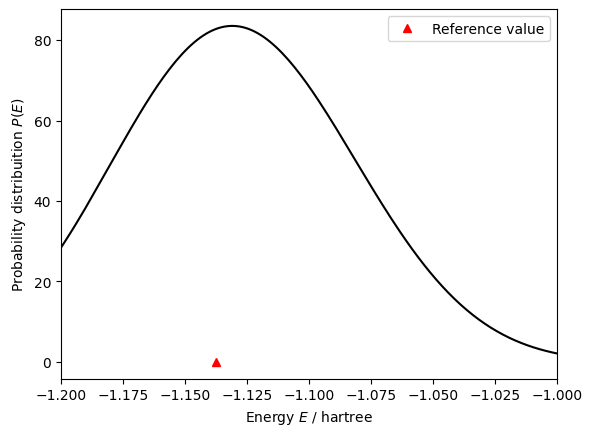

In [20]:
import matplotlib.pyplot as plt

x_energy = -phi / DELTAT
plt.plot(x_energy, posterior, "k-")
plt.xlim([-1.2,-1.0])
plt.plot(FCI_ENERGY, 0, "r^", label="Reference value")
plt.xlabel(r"Energy $E$ / hartree")
plt.ylabel(r"Probability distribuition $P(E)$")
plt.legend()